# Initial Setup

## Package and Data Loading

In [ ]:
#Import libraries
#Numpy for array work and various mathematical methods
import numpy as np
#Pandas for dataframe manipulation
import pandas as pd
#Matplotlib for plotting
import matplotlib.pyplot as plt
#Seaborn for density plot
import seaborn as sns
#SKlearn metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score

#train_test_split for splitting
from sklearn.model_selection import train_test_split
from sklearn import ensemble, svm
#Tensorflow, Keras and Layers for model building
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense



#Files and io to read dataset (only for google colab)
from google.colab import files
import io

In [ ]:
#Upload file to google colab
uploaded = files.upload()

Saving 05_Project2.csv to 05_Project2.csv


In [ ]:
#Read file from uploaded area
Data = pd.read_csv(io.BytesIO(uploaded['05_Project2.csv']))
#Alternate Command if running on local machine
#Data = pd.read_csv('05_Project2.csv')

## Data Cleaning and Preparation

In [ ]:
#Check Data Types
print('Data Types\n' + str(Data.dtypes))

Data Types
CatEdition           int64
SpringSummer          bool
ProductKey           int64
WeeksOut             int64
Status              object
SalePriceIncVAT    float64
ForecastPerWeek    float64
ActualsPerWeek     float64
DiscontinuedTF        bool
dtype: object


In [ ]:
#Check for duplicate rows
print('Any duplicated rows? ' + str(Data.duplicated().any()))

Any duplicated rows? False


In [ ]:
#Check for missing values
print('Any NA Values?\n'+str(Data.isna().any()))

Any NA Values?
CatEdition         False
SpringSummer       False
ProductKey         False
WeeksOut           False
Status             False
SalePriceIncVAT    False
ForecastPerWeek    False
ActualsPerWeek     False
DiscontinuedTF     False
dtype: bool


In [ ]:
#Look at Data head to get an idea of what it looks like
Data.head()

,CatEdition,SpringSummer,ProductKey,WeeksOut,Status,SalePriceIncVAT,ForecastPerWeek,ActualsPerWeek,DiscontinuedTF
0,89,True,8108,-11,RI,43.99,250.545,248.642,False
1,89,True,8108,-10,RI,43.99,255.700,244.333,False
2,89,True,8108,-9,RI,43.99,206.111,252.187,False
3,89,True,8108,-8,RI,43.99,188.625,254.764,False
4,89,True,8108,-7,RI,43.99,169.142,249.000,False


In [ ]:
#Copy Data to clean
CleanedData=Data.copy()
#Combine ProductKey and CatEdition to create a universal index
CleanedData['ProductCatComposite'] = CleanedData.ProductKey.astype(str)+ '-' + CleanedData.CatEdition.astype(str)
CleanedData['ProductCatComposite']=CleanedData['ProductCatComposite'].astype(str)
#Convert Booleans to integers
CleanedData['SpringSummer']=CleanedData['SpringSummer'].astype(int)
CleanedData['DiscontinuedTF']=CleanedData['DiscontinuedTF'].astype(int)
#Dummy Code Status variable
CleanedData['Status']=pd.get_dummies(CleanedData['Status'])['RO']
#Head to check check data
CleanedData.head()

,CatEdition,SpringSummer,ProductKey,WeeksOut,Status,SalePriceIncVAT,ForecastPerWeek,ActualsPerWeek,DiscontinuedTF,ProductCatComposite
0,89,1,8108,-11,0,43.99,250.545,248.642,0,8108-89
1,89,1,8108,-10,0,43.99,255.700,244.333,0,8108-89
2,89,1,8108,-9,0,43.99,206.111,252.187,0,8108-89
3,89,1,8108,-8,0,43.99,188.625,254.764,0,8108-89
4,89,1,8108,-7,0,43.99,169.142,249.000,0,8108-89


In [ ]:
#Find number of unique Product Catalogue combos
CleanedData['ProductCatComposite'].nunique()

178905

In [ ]:
#Create a wide format dataset using unique ProductCatComposite and other unique variables
WideData=CleanedData[['ProductCatComposite','DiscontinuedTF','SpringSummer', 'SalePriceIncVAT']].drop_duplicates()
#Reset index
WideData.reset_index(inplace=True, drop=True)
#Check to make sure correct size
len(WideData)

179075

In [ ]:
#Check why duplicates are appearing
WideData[WideData.duplicated(subset=['ProductCatComposite'],keep=False)]

,ProductCatComposite,DiscontinuedTF,SpringSummer,SalePriceIncVAT
2460,64787-94,1,0,10.00
2461,64787-94,1,0,7.00
2462,48548-94,1,0,10.00
2463,48548-94,1,0,7.00
2464,72726-94,1,0,10.00
...,...,...,...,...
175235,60588-94,1,0,49.99
175236,35549-94,1,0,39.99
175237,35549-94,1,0,49.99
175968,31945-93,0,1,12.00


In [ ]:
#Keep the first price of each pair
WideData=WideData.drop_duplicates(subset=['ProductCatComposite'],keep='first')
#Check length again
len(WideData)

178905

In [ ]:
#Sequentially merge weeks out data onto WideData, splitting into 6 datasets total
#Add suffixes for readability
FourWeekData=WideData.merge(CleanedData.loc[Data['WeeksOut']==-24][['ProductCatComposite', 'Status',	'ForecastPerWeek',	'ActualsPerWeek']],how='left', on='ProductCatComposite',suffixes=(None,'_24'))
FourWeekData=FourWeekData.merge(CleanedData.loc[Data['WeeksOut']==-23][['ProductCatComposite','Status',	'ForecastPerWeek',	'ActualsPerWeek']],how='left', on='ProductCatComposite',suffixes=(None,'_23'))
FourWeekData=FourWeekData.merge(CleanedData.loc[Data['WeeksOut']==-22][['ProductCatComposite','Status',	'ForecastPerWeek',	'ActualsPerWeek']],how='left', on='ProductCatComposite',suffixes=(None,'_22'))
FourWeekData=FourWeekData.merge(CleanedData.loc[Data['WeeksOut']==-21][['ProductCatComposite','Status',	'ForecastPerWeek',	'ActualsPerWeek']],how='left', on='ProductCatComposite',suffixes=(None,'_21'))

EightWeekData=FourWeekData
EightWeekData=EightWeekData.merge(CleanedData.loc[Data['WeeksOut']==-20][['ProductCatComposite','Status',	'ForecastPerWeek',	'ActualsPerWeek']],how='left', on='ProductCatComposite',suffixes=(None,'_20'))
EightWeekData=EightWeekData.merge(CleanedData.loc[Data['WeeksOut']==-19][['ProductCatComposite','Status',	'ForecastPerWeek',	'ActualsPerWeek']],how='left', on='ProductCatComposite',suffixes=(None,'_19'))
EightWeekData=EightWeekData.merge(CleanedData.loc[Data['WeeksOut']==-18][['ProductCatComposite','Status',	'ForecastPerWeek',	'ActualsPerWeek']],how='left', on='ProductCatComposite',suffixes=(None,'_18'))
EightWeekData=EightWeekData.merge(CleanedData.loc[Data['WeeksOut']==-17][['ProductCatComposite','Status',	'ForecastPerWeek',	'ActualsPerWeek']],how='left', on='ProductCatComposite',suffixes=(None,'_17'))

TwelveWeekData=EightWeekData
TwelveWeekData=TwelveWeekData.merge(CleanedData.loc[Data['WeeksOut']==-16][['ProductCatComposite','Status',	'ForecastPerWeek',	'ActualsPerWeek']],how='left', on='ProductCatComposite',suffixes=(None,'_16'))
TwelveWeekData=TwelveWeekData.merge(CleanedData.loc[Data['WeeksOut']==-15][['ProductCatComposite','Status',	'ForecastPerWeek',	'ActualsPerWeek']],how='left', on='ProductCatComposite',suffixes=(None,'_15'))
TwelveWeekData=TwelveWeekData.merge(CleanedData.loc[Data['WeeksOut']==-14][['ProductCatComposite','Status',	'ForecastPerWeek',	'ActualsPerWeek']],how='left', on='ProductCatComposite',suffixes=(None,'_14'))
TwelveWeekData=TwelveWeekData.merge(CleanedData.loc[Data['WeeksOut']==-13][['ProductCatComposite','Status',	'ForecastPerWeek',	'ActualsPerWeek']],how='left', on='ProductCatComposite',suffixes=(None,'_13'))

SixteenWeekData=TwelveWeekData
SixteenWeekData=SixteenWeekData.merge(CleanedData.loc[Data['WeeksOut']==-12][['ProductCatComposite','Status',	'ForecastPerWeek',	'ActualsPerWeek']],how='left', on='ProductCatComposite',suffixes=(None,'_12'))
SixteenWeekData=SixteenWeekData.merge(CleanedData.loc[Data['WeeksOut']==-11][['ProductCatComposite','Status',	'ForecastPerWeek',	'ActualsPerWeek']],how='left', on='ProductCatComposite',suffixes=(None,'_11'))
SixteenWeekData=SixteenWeekData.merge(CleanedData.loc[Data['WeeksOut']==-10][['ProductCatComposite','Status',	'ForecastPerWeek',	'ActualsPerWeek']],how='left', on='ProductCatComposite',suffixes=(None,'_10'))
SixteenWeekData=SixteenWeekData.merge(CleanedData.loc[Data['WeeksOut']==-9][['ProductCatComposite','Status',	'ForecastPerWeek',	'ActualsPerWeek']],how='left', on='ProductCatComposite',suffixes=(None,'_9'))

TwentyWeekData=SixteenWeekData
TwentyWeekData=TwentyWeekData.merge(CleanedData.loc[Data['WeeksOut']==-8][['ProductCatComposite','Status',	'ForecastPerWeek',	'ActualsPerWeek']],how='left', on='ProductCatComposite',suffixes=(None,'_8'))
TwentyWeekData=TwentyWeekData.merge(CleanedData.loc[Data['WeeksOut']==-7][['ProductCatComposite','Status',	'ForecastPerWeek',	'ActualsPerWeek']],how='left', on='ProductCatComposite',suffixes=(None,'_7'))
TwentyWeekData=TwentyWeekData.merge(CleanedData.loc[Data['WeeksOut']==-6][['ProductCatComposite','Status',	'ForecastPerWeek',	'ActualsPerWeek']],how='left', on='ProductCatComposite',suffixes=(None,'_6'))
TwentyWeekData=TwentyWeekData.merge(CleanedData.loc[Data['WeeksOut']==-5][['ProductCatComposite','Status',	'ForecastPerWeek',	'ActualsPerWeek']],how='left', on='ProductCatComposite',suffixes=(None,'_5'))

TwentyfourWeekData=TwentyWeekData
TwentyfourWeekData=TwentyfourWeekData.merge(CleanedData.loc[Data['WeeksOut']==-4][['ProductCatComposite','Status',	'ForecastPerWeek',	'ActualsPerWeek']],how='left', on='ProductCatComposite',suffixes=(None,'_4'))
TwentyfourWeekData=TwentyfourWeekData.merge(CleanedData.loc[Data['WeeksOut']==-3][['ProductCatComposite','Status',	'ForecastPerWeek',	'ActualsPerWeek']],how='left', on='ProductCatComposite',suffixes=(None,'_3'))
TwentyfourWeekData=TwentyfourWeekData.merge(CleanedData.loc[Data['WeeksOut']==-2][['ProductCatComposite','Status',	'ForecastPerWeek',	'ActualsPerWeek']],how='left', on='ProductCatComposite',suffixes=(None,'_2'))
TwentyfourWeekData=TwentyfourWeekData.merge(CleanedData.loc[Data['WeeksOut']==-1][['ProductCatComposite','Status',	'ForecastPerWeek',	'ActualsPerWeek']],how='left', on='ProductCatComposite',suffixes=(None,'_1'))


In [ ]:
#Add the _24 suffixes
new_names = [(i,i+'_24') for i in FourWeekData.iloc[:, 4:7].columns.values]
FourWeekData.rename(columns = dict(new_names), inplace=True)
EightWeekData.rename(columns = dict(new_names), inplace=True)
TwelveWeekData.rename(columns = dict(new_names), inplace=True)
SixteenWeekData.rename(columns = dict(new_names), inplace=True)
TwentyWeekData.rename(columns = dict(new_names), inplace=True)
TwentyfourWeekData.rename(columns = dict(new_names), inplace=True)

In [ ]:
#Reset Indexs
FourWeekData.set_index('ProductCatComposite',inplace=True)
EightWeekData.set_index('ProductCatComposite',inplace=True)
TwelveWeekData.set_index('ProductCatComposite',inplace=True)
SixteenWeekData.set_index('ProductCatComposite',inplace=True)
TwentyWeekData.set_index('ProductCatComposite',inplace=True)
TwentyfourWeekData.set_index('ProductCatComposite',inplace=True)

In [ ]:
#Drop any missing values
FourWeekData=FourWeekData.dropna()
EightWeekData=EightWeekData.dropna()
TwelveWeekData=TwelveWeekData.dropna()
SixteenWeekData=SixteenWeekData.dropna()
TwentyWeekData=TwentyWeekData.dropna()
TwentyfourWeekData=TwentyfourWeekData.dropna()

In [ ]:
#Get head to see new format
EightWeekData.head()

,DiscontinuedTF,SpringSummer,SalePriceIncVAT,Status_24,ForecastPerWeek_24,ActualsPerWeek_24,Status_23,ForecastPerWeek_23,ActualsPerWeek_23,Status_22,...,ActualsPerWeek_20,Status_19,ForecastPerWeek_19,ActualsPerWeek_19,Status_18,ForecastPerWeek_18,ActualsPerWeek_18,Status_17,ForecastPerWeek_17,ActualsPerWeek_17
ProductCatComposite,,,,,,,,,,,,,,,,,,,,,
8108-89,0,1,43.99,0.0,208.666,0.0,0.0,217.695,0.0,0.0,...,0.0,0.0,263.315,0.000,0.0,563.444,0.000,0.0,596.529,0.000
8108-90,0,0,32.99,1.0,49.708,68.0,1.0,43.130,60.0,1.0,...,48.2,1.0,32.000,44.833,1.0,32.000,44.571,1.0,31.058,49.125
8108-91,0,1,23.99,1.0,26.583,18.0,1.0,28.217,18.0,1.0,...,18.0,1.0,34.105,16.000,1.0,36.555,15.428,1.0,32.941,14.250
8108-92,1,0,23.99,1.0,8.041,4.0,1.0,7.913,6.0,1.0,...,5.0,1.0,6.842,4.833,1.0,6.833,4.857,1.0,7.117,5.000
71280-89,0,1,44.99,0.0,5.875,12.0,0.0,5.869,19.0,0.0,...,27.2,0.0,272.526,28.500,0.0,242.055,27.714,0.0,249.235,27.875


## Metric Functions

In [ ]:
#Create metric function for SVM and Forest Models
def get_metrics(dataset_, y_true, model):
    #Get predictions
    y_pred = model.predict(dataset_)
    #Use Binary average as two class problem
    p = precision_score(y_true, y_pred, average='binary')
    r = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    a = accuracy_score(y_true, y_pred)
    return (a, p, r, f1)

In [ ]:
#Same as above with one change
def get_metrics_nn(dataset_, y_true, model):
    #NN returns probabilities, round to get predictions
    prob_pred = model.predict(dataset_)
    y_pred= np.around(prob_pred)
    #Use Binary average
    p = precision_score(y_true, y_pred, average='binary')
    r = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    a = accuracy_score(y_true, y_pred)
    return (a, p, r, f1)

In [ ]:
#Define confusion matrix function 
def get_confusion_matrix(dataset_, y_true, model):
    y_pred= model.predict(dataset_)
    cm = confusion_matrix(y_true, y_pred)
    return cm

# EDA

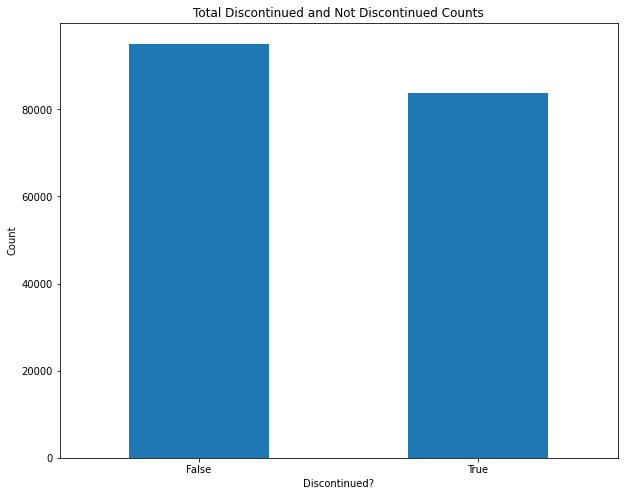

In [ ]:
#Set plot size
plt.figure(figsize=(10,8))
#Create a bar chart using pandas syntax and value counts
WideData['DiscontinuedTF'].value_counts().plot(kind='bar')
#change xtick labels to True and False
plt.xticks([0,1], ['False','True'], rotation='horizontal')
#Add x and ylabels, as well as title
plt.xlabel('Discontinued?')
plt.ylabel('Count')
plt.title('Total Discontinued and Not Discontinued Counts')
plt.show()

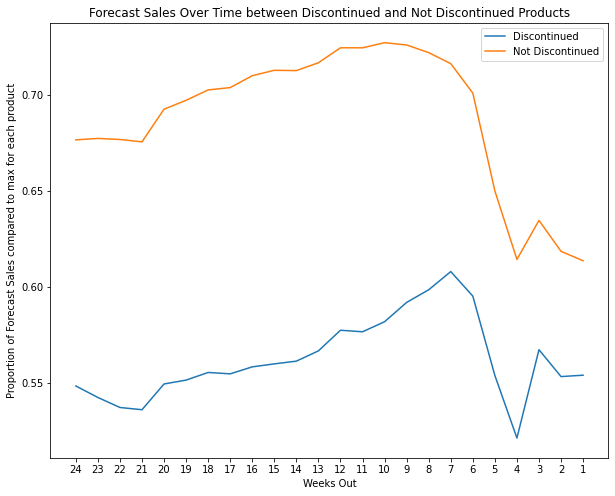

In [ ]:
#Find the max forecast value for each product catalogue composite
maxvalsforecastTrue=TwentyfourWeekData.loc[TwentyfourWeekData['DiscontinuedTF']==1].iloc[:,list(range(4,75,3))].max(axis=1)
maxvalsforecastFalse=TwentyfourWeekData.loc[TwentyfourWeekData['DiscontinuedTF']==0].iloc[:,list(range(4,75,3))].max(axis=1)

#scale the forecast values using these maxs
forecastscaledTrue=(TwentyfourWeekData.loc[TwentyfourWeekData['DiscontinuedTF']==1].iloc[:,list(range(4,75,3))].T/maxvalsforecastTrue).T
forecastscaledFalse=(TwentyfourWeekData.loc[TwentyfourWeekData['DiscontinuedTF']==0].iloc[:,list(range(4,75,3))].T/maxvalsforecastFalse).T

#figure size
plt.figure(figsize=(10,8))
#Plot the mean scaled forecasts for the two target classes
plt.plot(forecastscaledTrue.mean(), label='Discontinued')
plt.plot(forecastscaledFalse.mean(), label='Not Discontinued')
#Change xticks to weeks out
plt.xticks(list(range(0,24)), list(range(24,0,-1)), rotation='horizontal')
#Add labels
plt.xlabel('Weeks Out')
plt.ylabel('Proportion of Forecast Sales compared to max for each product')
plt.title('Forecast Sales Over Time between Discontinued and Not Discontinued Products')
#Add legend
plt.legend(loc='best')
plt.show()

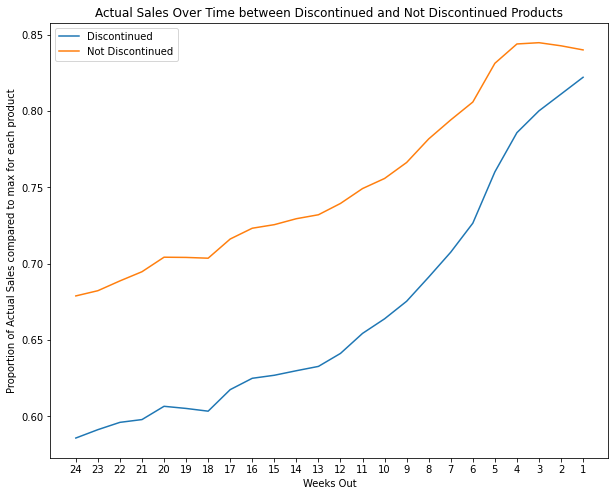

In [ ]:
#Same as above except with actual values
maxvalsactualTrue=TwentyfourWeekData.loc[TwentyfourWeekData['DiscontinuedTF']==1].iloc[:,list(range(5,75,3))].max(axis=1)
maxvalsactualFalse=TwentyfourWeekData.loc[TwentyfourWeekData['DiscontinuedTF']==0].iloc[:,list(range(5,75,3))].max(axis=1)

actualscaledTrue=(TwentyfourWeekData.loc[TwentyfourWeekData['DiscontinuedTF']==1].iloc[:,list(range(5,75,3))].T/maxvalsactualTrue).T
actualscaledFalse=(TwentyfourWeekData.loc[TwentyfourWeekData['DiscontinuedTF']==0].iloc[:,list(range(5,75,3))].T/maxvalsactualFalse).T

plt.figure(figsize=(10,8))
plt.plot(actualscaledTrue.mean(), label='Discontinued')
plt.plot(actualscaledFalse.mean(), label='Not Discontinued')
plt.xticks(list(range(0,24)), list(range(24,0,-1)), rotation='horizontal')
plt.xlabel('Weeks Out')
plt.ylabel('Proportion of Actual Sales compared to max for each product')
plt.title('Actual Sales Over Time between Discontinued and Not Discontinued Products')
plt.legend(loc='best')
plt.show()

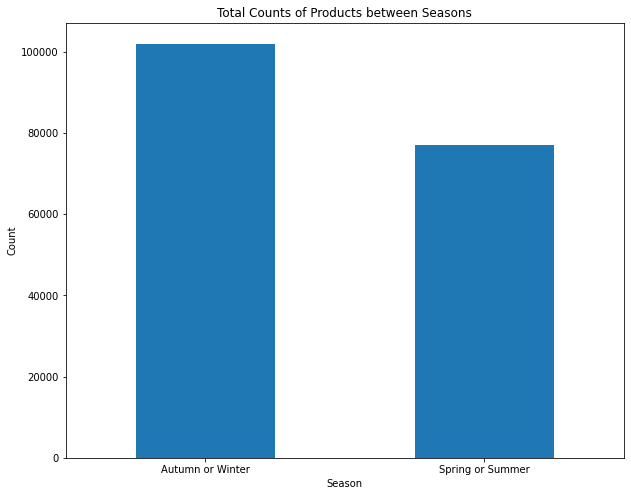

In [ ]:
#Same as DiscontinuedTF barplots but with SpringSummer
plt.figure(figsize=(10,8))
WideData['SpringSummer'].value_counts().plot(kind='bar')
plt.xticks([0,1], ['Autumn or Winter','Spring or Summer'], rotation='horizontal')
plt.xlabel('Season')
plt.ylabel('Count')
plt.title('Total Counts of Products between Seasons')
plt.show()

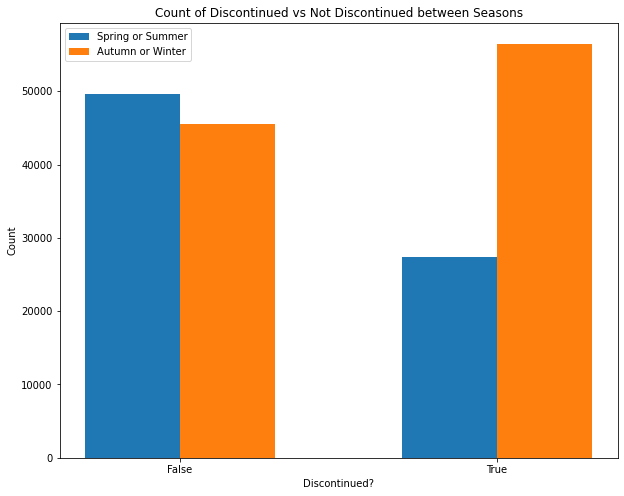

In [ ]:
#Set width
width=0.3
#Get value counts and index
a=WideData['DiscontinuedTF'].loc[WideData['SpringSummer']==1].value_counts()
x = list(a.index)
y = list(a)
#Repeat for AutumnWinter
b=WideData['DiscontinuedTF'].loc[WideData['SpringSummer']==0].value_counts()
x2 = list(b.index)
y2 = list(b)
plt.figure(figsize=(10,8))
#Create bar plot using Spring and Summer
plt.bar(x,y,width,label='Spring or Summer')
#Creat offsetted bar plots for Autumn and Winter
plt.bar([x+width for x in x2],y2,width,label='Autumn or Winter')
#Set xticks to middle
plt.xticks([0.15,1.15], ['False','True'], rotation='horizontal')
#Add labels and legend
plt.xlabel('Discontinued?')
plt.ylabel('Count')
plt.title('Count of Discontinued vs Not Discontinued between Seasons')
plt.legend(loc='best')
plt.show()

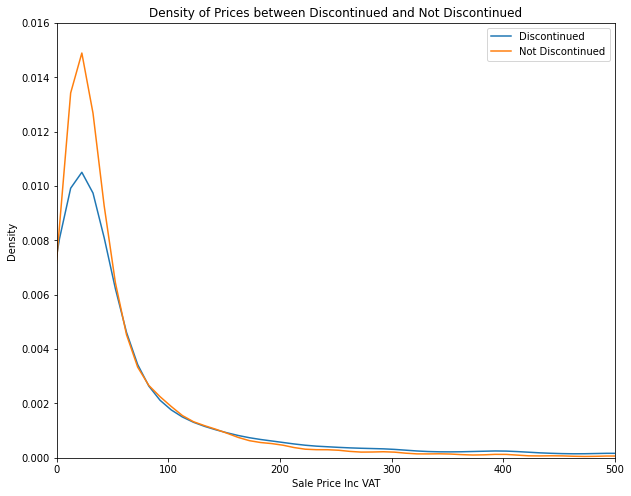

In [ ]:
plt.figure(figsize=(10,8))
#Densitpy plots for price, using seaborn (may take slightly longer to run)
WideData.loc[WideData['DiscontinuedTF']==1].SalePriceIncVAT.plot.density(label='Discontinued')
WideData.loc[WideData['DiscontinuedTF']==0].SalePriceIncVAT.plot.density(label='Not Discontinued')
#Set lims to make more viewable
plt.xlim(0,500)
plt.ylim(0,0.016)
#Add labels
plt.xlabel('Sale Price Inc VAT')
plt.title('Density of Prices between Discontinued and Not Discontinued')
plt.legend(loc='best')
plt.show()

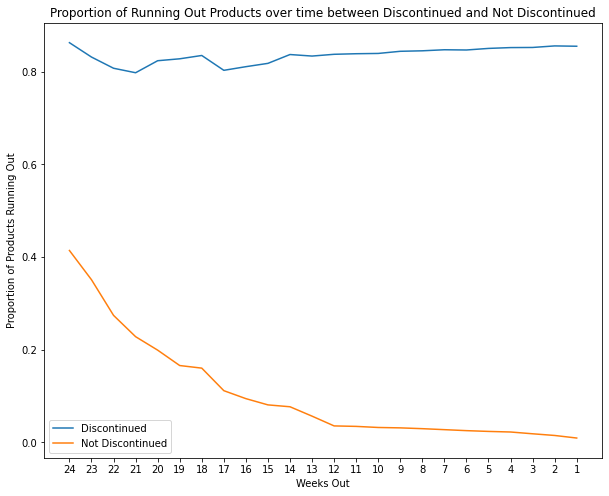

In [ ]:
plt.figure(figsize=(10,8))
#Take mean of Status to find proportion RO
plt.plot(TwentyfourWeekData.loc[TwentyfourWeekData['DiscontinuedTF']==1].iloc[:,list(range(3,75,3))].mean(), label='Discontinued')
plt.plot(TwentyfourWeekData.loc[TwentyfourWeekData['DiscontinuedTF']==0].iloc[:,list(range(3,75,3))].mean(), label='Not Discontinued')
#xticks
plt.xticks(list(range(0,24)), list(range(24,0,-1)), rotation='horizontal')
#labels and legend
plt.xlabel('Weeks Out')
plt.ylabel('Proportion of Products Running Out')
plt.title('Proportion of Running Out Products over time between Discontinued and Not Discontinued')
plt.legend(loc='best')
plt.show()

#Model Creation, Fitting, and Comparison

## Four Week Data Models

In [ ]:
#Comments are only in Four Week Models, as the code is syntaxically the same for all other datasets

### Data Splitting

In [ ]:
#Perform data splitting into train, val, and test
FourTrain, FourTest=train_test_split(FourWeekData, train_size=0.8, random_state=31415)
FourTrain, FourVal=train_test_split(FourTrain, train_size=0.9, random_state=31415)

In [ ]:
#Split into Target and Feature Variables
FourTrainY=FourTrain['DiscontinuedTF']
FourTrainX=FourTrain.iloc[:,1:]

FourValY=FourVal['DiscontinuedTF']
FourValX=FourVal.iloc[:,1:]

FourTestY=FourTest['DiscontinuedTF']
FourTestX=FourTest.iloc[:,1:]

### Random Forest

In [ ]:
#Call Random forest with set random state
FourWeekForest = ensemble.RandomForestClassifier(random_state=31415)
#Fit forest using training data
FourWeekForest = FourWeekForest.fit(FourTrainX, FourTrainY)

In [ ]:
#Get training metrics
FourForestTrainMetrics=get_metrics(FourTrainX, FourTrainY, FourWeekForest)
print('Training Accuracy Score:'+ str(FourForestTrainMetrics[0]))
print('Training Precision Score:'+ str(FourForestTrainMetrics[1]))
print('Training Recall Score:'+ str(FourForestTrainMetrics[2]))
print('Training F1 Score:'+ str(FourForestTrainMetrics[3]))

Training Accuracy Score:0.9996963445239307
Training Precision Score:0.9996354799513973
Training Recall Score:0.9996759690550447
Training F1 Score:0.999655724093238


In [ ]:
#And validation metrics
FourForestValMetrics=get_metrics(FourValX, FourValY, FourWeekForest)
print('Validation Accuracy Score:'+ str(FourForestValMetrics[0]))
print('Validation Precision Score:'+ str(FourForestValMetrics[1]))
print('Validation Recall Score:'+ str(FourForestValMetrics[2]))
print('Validation F1 Score:'+ str(FourForestValMetrics[3]))

Validation Accuracy Score:0.7818503335744715
Validation Precision Score:0.7670932358318099
Validation Recall Score:0.7444996451383961
Validation F1 Score:0.7556275886907978


### SVM

In [ ]:
#Same as with forest, but using SVC
FourWeekSVM = svm.SVC(random_state=31415)
FourWeekSVM = FourWeekSVM.fit(FourTrainX, FourTrainY)

In [ ]:
FourSVMTrainMetrics=get_metrics(FourTrainX, FourTrainY, FourWeekSVM)
print('Training Accuracy Score:'+ str(FourSVMTrainMetrics[0]))
print('Training Precision Score:'+ str(FourSVMTrainMetrics[1]))
print('Training Recall Score:'+ str(FourSVMTrainMetrics[2]))
print('Training F1 Score:'+ str(FourSVMTrainMetrics[3]))

Training Accuracy Score:0.6601559360180049
Training Precision Score:0.631611973598587
Training Recall Score:0.5503868119405403
Training F1 Score:0.5882085578858516


In [ ]:
FourSVMValMetrics=get_metrics(FourValX, FourValY, FourWeekSVM)
print('Validation Accuracy Score:'+ str(FourSVMValMetrics[0]))
print('Validation Precision Score:'+ str(FourSVMValMetrics[1]))
print('Validation Recall Score:'+ str(FourSVMValMetrics[2]))
print('Validation F1 Score:'+ str(FourSVMValMetrics[3]))

Validation Accuracy Score:0.6600755566272808
Validation Precision Score:0.6469605180697723
Validation Recall Score:0.5495031937544358
Validation F1 Score:0.5942626882855224


### Neural Network

In [ ]:
#Set Neural Network to be sequential
FourWeekNN = Sequential()
#Add a dense layer
FourWeekNN.add(Dense(12, activation="relu"))
#and an output layer
FourWeekNN.add(Dense(1, activation="sigmoid"))

In [ ]:
#Set keras seed
keras.utils.set_random_seed(31415)
#Compile using BCE and RMSProp
FourWeekNN.compile(
    loss="binary_crossentropy", optimizer="rmsprop", 
    metrics=["acc"]
)
#Fit with appropriate epochs and batch size
FourWeekNN.fit(FourTrainX, FourTrainY, epochs=10, batch_size=128)

Epoch 1/10
875/875 [==============================] - 3s 2ms/step - loss: 2.1261 - acc: 0.6521
Epoch 2/10
875/875 [==============================] - 2s 2ms/step - loss: 1.1788 - acc: 0.6942
Epoch 3/10
875/875 [==============================] - 2s 2ms/step - loss: 0.9834 - acc: 0.7073
Epoch 4/10
875/875 [==============================] - 2s 2ms/step - loss: 0.8800 - acc: 0.7128
Epoch 5/10
875/875 [==============================] - 2s 2ms/step - loss: 0.8398 - acc: 0.7155
Epoch 6/10
875/875 [==============================] - 2s 2ms/step - loss: 0.8134 - acc: 0.7187
Epoch 7/10
875/875 [==============================] - 2s 2ms/step - loss: 0.7933 - acc: 0.7206
Epoch 8/10
875/875 [==============================] - 2s 2ms/step - loss: 0.7767 - acc: 0.7234
Epoch 9/10
875/875 [==============================] - 2s 2ms/step - loss: 0.7751 - acc: 0.7237
Epoch 10/10
875/875 [==============================] - 2s 2ms/step - loss: 0.7661 - acc: 0.7241


In [ ]:
#Summary to infer output shape and parameters for all following models
FourWeekNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 12)                180       
                                                                 
 dense_3 (Dense)             (None, 1)                 13        
                                                                 
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Metrics use nn version
FourNNTrainMetrics=get_metrics_nn(FourTrainX, FourTrainY, FourWeekNN)
print('Training Accuracy Score:'+ str(FourNNTrainMetrics[0]))
print('Training Precision Score:'+ str(FourNNTrainMetrics[1]))
print('Training Recall Score:'+ str(FourNNTrainMetrics[2]))
print('Training F1 Score:'+ str(FourNNTrainMetrics[3]))

Training Accuracy Score:0.7462958497441257
Training Precision Score:0.6920878597468262
Training Recall Score:0.7650978168415083
Training F1 Score:0.7267638147453469


In [ ]:
FourNNValMetrics=get_metrics_nn(FourValX, FourValY, FourWeekNN)
print('Validation Accuracy Score:'+ str(FourNNValMetrics[0]))
print('Validation Precision Score:'+ str(FourNNValMetrics[1]))
print('Validation Recall Score:'+ str(FourNNValMetrics[2]))
print('Validation F1 Score:'+ str(FourNNValMetrics[3]))

Validation Accuracy Score:0.7486536452053694
Validation Precision Score:0.7067743530575243
Validation Recall Score:0.7608232789212207
Validation F1 Score:0.7328035546441084


## Eight Week Data Models

### Data Splitting

In [ ]:
EightTrain, EightTest=train_test_split(EightWeekData, train_size=0.8, random_state=31415)
EightTrain, EightVal=train_test_split(EightTrain, train_size=0.9, random_state=31415)

In [ ]:
EightTrainY=EightTrain['DiscontinuedTF']
EightTrainX=EightTrain.iloc[:,1:]

EightValY=EightVal['DiscontinuedTF']
EightValX=EightVal.iloc[:,1:]

EightTestY=EightTest['DiscontinuedTF']
EightTestX=EightTest.iloc[:,1:]

### Random Forest

In [ ]:
EightWeekForest = ensemble.RandomForestClassifier(random_state=31415)
EightWeekForest = EightWeekForest.fit(EightTrainX, EightTrainY)

In [ ]:
EightForestTrainMetrics=get_metrics(EightTrainX, EightTrainY, EightWeekForest)
print('Training Accuracy Score:'+ str(EightForestTrainMetrics[0]))
print('Training Precision Score:'+ str(EightForestTrainMetrics[1]))
print('Training Recall Score:'+ str(EightForestTrainMetrics[2]))
print('Training F1 Score:'+ str(EightForestTrainMetrics[3]))

Training Accuracy Score:0.9999547756874095
Training Precision Score:0.9999170141698305
Training Recall Score:0.9999792522511307
Training F1 Score:0.9999481322420357


In [ ]:
EightForestValMetrics=get_metrics(EightValX, EightValY, EightWeekForest)
print('Validation Accuracy Score:'+ str(EightForestValMetrics[0]))
print('Validation Precision Score:'+ str(EightForestValMetrics[1]))
print('Validation Recall Score:'+ str(EightForestValMetrics[2]))
print('Validation F1 Score:'+ str(EightForestValMetrics[3]))

Validation Accuracy Score:0.8385022385022385
Validation Precision Score:0.826306586360987
Validation Recall Score:0.7959947594984091
Validation F1 Score:0.8108674928503338


### SVM

In [ ]:
EightWeekSVM = svm.SVC(random_state=31415)
EightWeekSVM = EightWeekSVM.fit(EightTrainX, EightTrainY)

In [ ]:
EightSVMTrainMetrics=get_metrics(EightTrainX, EightTrainY, EightWeekSVM)
print('Training Accuracy Score:'+ str(EightSVMTrainMetrics[0]))
print('Training Precision Score:'+ str(EightSVMTrainMetrics[1]))
print('Training Recall Score:'+ str(EightSVMTrainMetrics[2]))
print('Training F1 Score:'+ str(EightSVMTrainMetrics[3]))

Training Accuracy Score:0.6686776410998553
Training Precision Score:0.6395868027900465
Training Recall Score:0.5498153450350637
Training F1 Score:0.5913132733094576


In [ ]:
EightSVMValMetrics=get_metrics(EightValX, EightValY, EightWeekSVM)
print('Validation Accuracy Score:'+ str(EightSVMValMetrics[0]))
print('Validation Precision Score:'+ str(EightSVMValMetrics[1]))
print('Validation Recall Score:'+ str(EightSVMValMetrics[2]))
print('Validation F1 Score:'+ str(EightSVMValMetrics[3]))

Validation Accuracy Score:0.6752136752136753
Validation Precision Score:0.6450782757881193
Validation Recall Score:0.5629795994759499
Validation F1 Score:0.6012392564461324


### Neural Network

In [ ]:
EightWeekNN = Sequential()
EightWeekNN.add(Dense(12, activation="relu"))
EightWeekNN.add(Dense(1, activation="sigmoid"))

In [ ]:
tf.keras.utils.set_random_seed(31415)
#And binary crossentropy
EightWeekNN.compile(
    loss="binary_crossentropy", optimizer="rmsprop", 
    metrics=["acc"]
)

EightWeekNN.fit(EightTrainX, EightTrainY, epochs=10, batch_size=128)

NameError: ignored

In [ ]:
EightNNTrainMetrics=get_metrics_nn(EightTrainX, EightTrainY, EightWeekNN)
print('Training Accuracy Score:'+ str(EightNNTrainMetrics[0]))
print('Training Precision Score:'+ str(EightNNTrainMetrics[1]))
print('Training Recall Score:'+ str(EightNNTrainMetrics[2]))
print('Training F1 Score:'+ str(EightNNTrainMetrics[3]))

In [ ]:
EightNNValMetrics=get_metrics_nn(EightValX, EightValY, EightWeekNN)
print('Validation Accuracy Score:'+ str(EightNNValMetrics[0]))
print('Validation Precision Score:'+ str(EightNNValMetrics[1]))
print('Validation Recall Score:'+ str(EightNNValMetrics[2]))
print('Validation F1 Score:'+ str(EightNNValMetrics[3]))

## Twelve Week Data Models

### Data Splitting

In [ ]:
TwelveTrain, TwelveTest=train_test_split(TwelveWeekData, train_size=0.8, random_state=31415)
TwelveTrain, TwelveVal=train_test_split(TwelveTrain, train_size=0.9, random_state=31415)

In [ ]:
TwelveTrainY=TwelveTrain['DiscontinuedTF']
TwelveTrainX=TwelveTrain.iloc[:,1:]

TwelveValY=TwelveVal['DiscontinuedTF']
TwelveValX=TwelveVal.iloc[:,1:]

TwelveTestY=TwelveTest['DiscontinuedTF']
TwelveTestX=TwelveTest.iloc[:,1:]

### Random Forest

In [ ]:
TwelveWeekForest = ensemble.RandomForestClassifier(random_state=31415)
TwelveWeekForest = TwelveWeekForest.fit(TwelveTrainX, TwelveTrainY)

In [ ]:
TwelveForestTrainMetrics=get_metrics(TwelveTrainX, TwelveTrainY, TwelveWeekForest)
print('Training Accuracy Score:'+ str(TwelveForestTrainMetrics[0]))
print('Training Precision Score:'+ str(TwelveForestTrainMetrics[1]))
print('Training Recall Score:'+ str(TwelveForestTrainMetrics[2]))
print('Training F1 Score:'+ str(TwelveForestTrainMetrics[3]))

Training Accuracy Score:0.9999634956559831
Training Precision Score:0.9999577032885694
Training Recall Score:0.9999577032885694
Training F1 Score:0.9999577032885694


In [ ]:
TwelveForestValMetrics=get_metrics(TwelveValX, TwelveValY, TwelveWeekForest)
print('Validation Accuracy Score:'+ str(TwelveForestValMetrics[0]))
print('Validation Precision Score:'+ str(TwelveForestValMetrics[1]))
print('Validation Recall Score:'+ str(TwelveForestValMetrics[2]))
print('Validation F1 Score:'+ str(TwelveForestValMetrics[3]))

Validation Accuracy Score:0.8901116951379764
Validation Precision Score:0.8839060376625898
Validation Recall Score:0.8601927073493293
Validation F1 Score:0.8718881654538492


### SVM

In [ ]:
TwelveWeekSVM = svm.SVC(random_state=31415)
TwelveWeekSVM = TwelveWeekSVM.fit(TwelveTrainX, TwelveTrainY)

In [ ]:
TwelveSVMTrainMetrics=get_metrics(TwelveTrainX, TwelveTrainY, TwelveWeekSVM)
print('Training Accuracy Score:'+ str(TwelveSVMTrainMetrics[0]))
print('Training Precision Score:'+ str(TwelveSVMTrainMetrics[1]))
print('Training Recall Score:'+ str(TwelveSVMTrainMetrics[2]))
print('Training F1 Score:'+ str(TwelveSVMTrainMetrics[3]))

Training Accuracy Score:0.6746641600350441
Training Precision Score:0.6401792598303778
Training Recall Score:0.561911811356667
Training F1 Score:0.5984975616348872


In [ ]:
TwelveSVMValMetrics=get_metrics(TwelveValX, TwelveValY, TwelveWeekSVM)
print('Validation Accuracy Score:'+ str(TwelveSVMValMetrics[0]))
print('Validation Precision Score:'+ str(TwelveSVMValMetrics[1]))
print('Validation Recall Score:'+ str(TwelveSVMValMetrics[2]))
print('Validation F1 Score:'+ str(TwelveSVMValMetrics[3]))

Validation Accuracy Score:0.6709099868593955
Validation Precision Score:0.6392980935875217
Validation Recall Score:0.5575288116380125
Validation F1 Score:0.595620143304067


### Neural Network

In [ ]:
TwelveWeekNN = Sequential()
TwelveWeekNN.add(Dense(12, activation="relu"))
TwelveWeekNN.add(Dense(1, activation="sigmoid"))

In [ ]:
tf.keras.utils.set_random_seed(31415)
#And binary crossentropy
TwelveWeekNN.compile(
    loss="binary_crossentropy", optimizer="rmsprop", 
    metrics=["acc"]
)

TwelveWeekNN.fit(TwelveTrainX, TwelveTrainY, epochs=10,batch_size=128)

Epoch 1/10
857/857 [==============================] - 4s 4ms/step - loss: 0.5158 - acc: 0.8136
Epoch 2/10
857/857 [==============================] - 3s 4ms/step - loss: 0.4984 - acc: 0.8210
Epoch 3/10
857/857 [==============================] - 3s 4ms/step - loss: 0.4815 - acc: 0.8270
Epoch 4/10
857/857 [==============================] - 3s 4ms/step - loss: 0.4671 - acc: 0.8280
Epoch 5/10
857/857 [==============================] - 3s 4ms/step - loss: 0.4499 - acc: 0.8313
Epoch 6/10
857/857 [==============================] - 2s 2ms/step - loss: 0.4476 - acc: 0.8320
Epoch 7/10
857/857 [==============================] - 2s 2ms/step - loss: 0.4389 - acc: 0.8346
Epoch 8/10
857/857 [==============================] - 2s 2ms/step - loss: 0.4325 - acc: 0.8368
Epoch 9/10
857/857 [==============================] - 2s 2ms/step - loss: 0.4305 - acc: 0.8374
Epoch 10/10
857/857 [==============================] - 2s 2ms/step - loss: 0.4229 - acc: 0.8395


In [ ]:
TwelveNNTrainMetrics=get_metrics_nn(TwelveTrainX, TwelveTrainY, TwelveWeekNN)
print('Training Accuracy Score:'+ str(TwelveNNTrainMetrics[0]))
print('Training Precision Score:'+ str(TwelveNNTrainMetrics[1]))
print('Training Recall Score:'+ str(TwelveNNTrainMetrics[2]))
print('Training F1 Score:'+ str(TwelveNNTrainMetrics[3]))

In [ ]:
TwelveNNValMetrics=get_metrics_nn(TwelveValX, TwelveValY, TwelveWeekNN)
print('Validation Accuracy Score:'+ str(TwelveNNValMetrics[0]))
print('Validation Precision Score:'+ str(TwelveNNValMetrics[1]))
print('Validation Recall Score:'+ str(TwelveNNValMetrics[2]))
print('Validation F1 Score:'+ str(TwelveNNValMetrics[3]))

Validation Accuracy Score:0.8153745072273325
Validation Precision Score:0.8664259927797834
Validation Recall Score:0.6801435858681277
Validation F1 Score:0.7620660457239627


## Sixteen Week Data Models

### Data Splitting

In [ ]:
SixteenTrain, SixteenTest=train_test_split(SixteenWeekData, train_size=0.8, random_state=31415)
SixteenTrain, SixteenVal=train_test_split(SixteenTrain, train_size=0.9, random_state=31415)

In [ ]:
SixteenTrainY=SixteenTrain['DiscontinuedTF']
SixteenTrainX=SixteenTrain.iloc[:,1:]

SixteenValY=SixteenVal['DiscontinuedTF']
SixteenValX=SixteenVal.iloc[:,1:]

SixteenTestY=SixteenTest['DiscontinuedTF']
SixteenTestX=SixteenTest.iloc[:,1:]

### Random Forest

In [ ]:
SixteenWeekForest = ensemble.RandomForestClassifier(random_state=31415)
SixteenWeekForest = SixteenWeekForest.fit(SixteenTrainX, SixteenTrainY)

In [ ]:
SixteenForestTrainMetrics=get_metrics(SixteenTrainX, SixteenTrainY, SixteenWeekForest)
print('Training Accuracy Score:'+ str(SixteenForestTrainMetrics[0]))
print('Training Precision Score:'+ str(SixteenForestTrainMetrics[1]))
print('Training Recall Score:'+ str(SixteenForestTrainMetrics[2]))
print('Training F1 Score:'+ str(SixteenForestTrainMetrics[3]))

Training Accuracy Score:0.9999117494567076
Training Precision Score:0.9998597524630973
Training Recall Score:0.9998597524630973
Training F1 Score:0.9998597524630973


In [ ]:
SixteenForestValMetrics=get_metrics(SixteenValX, SixteenValY, SixteenWeekForest)
print('Validation Accuracy Score:'+ str(SixteenForestValMetrics[0]))
print('Validation Precision Score:'+ str(SixteenForestValMetrics[1]))
print('Validation Recall Score:'+ str(SixteenForestValMetrics[2]))
print('Validation F1 Score:'+ str(SixteenForestValMetrics[3]))

Validation Accuracy Score:0.9433138091928919
Validation Precision Score:0.915177219024538
Validation Recall Score:0.9121376811594203
Validation F1 Score:0.9136549221230907


### SVM

In [ ]:
SixteenWeekSVM = svm.SVC(random_state=31415)
SixteenWeekSVM = SixteenWeekSVM.fit(SixteenTrainX, SixteenTrainY)

In [ ]:
SixteenSVMTrainMetrics=get_metrics(SixteenTrainX, SixteenTrainY, SixteenWeekSVM)
print('Training Accuracy Score:'+ str(SixteenSVMTrainMetrics[0]))
print('Training Precision Score:'+ str(SixteenSVMTrainMetrics[1]))
print('Training Recall Score:'+ str(SixteenSVMTrainMetrics[2]))
print('Training F1 Score:'+ str(SixteenSVMTrainMetrics[3]))

Training Accuracy Score:0.6950723102889103
Training Precision Score:0.7470489038785835
Training Recall Score:0.046597244135899864
Training F1 Score:0.08772277227722772


In [ ]:
SixteenSVMValMetrics=get_metrics(SixteenValX, SixteenValY, SixteenWeekSVM)
print('Validation Accuracy Score:'+ str(SixteenSVMValMetrics[0]))
print('Validation Precision Score:'+ str(SixteenSVMValMetrics[1]))
print('Validation Recall Score:'+ str(SixteenSVMValMetrics[2]))
print('Validation F1 Score:'+ str(SixteenSVMValMetrics[3]))

Validation Accuracy Score:0.680532115556438
Validation Precision Score:0.7582417582417582
Validation Recall Score:0.041666666666666664
Validation F1 Score:0.07899255867200916


### Neural Network

In [ ]:
SixteenWeekNN = Sequential()
SixteenWeekNN.add(Dense(12, activation="relu"))
SixteenWeekNN.add(Dense(1, activation="sigmoid"))

In [ ]:
tf.keras.utils.set_random_seed(31415)
#And binary crossentropy
SixteenWeekNN.compile(
    loss="binary_crossentropy", optimizer="rmsprop", 
    metrics=["acc"]
)

SixteenWeekNN.fit(SixteenTrainX, SixteenTrainY, epochs=10, batch_size=128)

Epoch 1/10
709/709 [==============================] - 2s 2ms/step - loss: 1.8189 - acc: 0.7101
Epoch 2/10
709/709 [==============================] - 1s 2ms/step - loss: 0.6073 - acc: 0.8006
Epoch 3/10
709/709 [==============================] - 1s 2ms/step - loss: 0.4974 - acc: 0.8577
Epoch 4/10
709/709 [==============================] - 1s 2ms/step - loss: 0.4133 - acc: 0.8755
Epoch 5/10
709/709 [==============================] - 1s 2ms/step - loss: 0.3556 - acc: 0.8867
Epoch 6/10
709/709 [==============================] - 1s 2ms/step - loss: 0.3103 - acc: 0.8966
Epoch 7/10
709/709 [==============================] - 1s 2ms/step - loss: 0.2924 - acc: 0.9030
Epoch 8/10
709/709 [==============================] - 1s 2ms/step - loss: 0.2777 - acc: 0.9096
Epoch 9/10
709/709 [==============================] - 1s 2ms/step - loss: 0.2670 - acc: 0.9147
Epoch 10/10
709/709 [==============================] - 1s 2ms/step - loss: 0.2551 - acc: 0.9187


In [ ]:
SixteenNNTrainMetrics=get_metrics_nn(SixteenTrainX, SixteenTrainY, SixteenWeekNN)
print('Training Accuracy Score:'+ str(SixteenNNTrainMetrics[0]))
print('Training Precision Score:'+ str(SixteenNNTrainMetrics[1]))
print('Training Recall Score:'+ str(SixteenNNTrainMetrics[2]))
print('Training F1 Score:'+ str(SixteenNNTrainMetrics[3]))

Training Accuracy Score:0.9235419355550407
Training Precision Score:0.913221558719951
Training Recall Score:0.8364713719715298
Training F1 Score:0.8731631439289963


In [ ]:
SixteenNNValMetrics=get_metrics_nn(SixteenValX, SixteenValY, SixteenWeekNN)
print('Validation Accuracy Score:'+ str(SixteenNNValMetrics[0]))
print('Validation Precision Score:'+ str(SixteenNNValMetrics[1]))
print('Validation Recall Score:'+ str(SixteenNNValMetrics[2]))
print('Validation F1 Score:'+ str(SixteenNNValMetrics[3]))

Validation Accuracy Score:0.9247493298917899
Validation Precision Score:0.9242524916943522
Validation Recall Score:0.839975845410628
Validation F1 Score:0.8801012337867764


## Twenty Week Data Models

### Data Splitting

In [ ]:
TwentyTrain, TwentyTest=train_test_split(TwentyWeekData, train_size=0.8, random_state=31415)
TwentyTrain, TwentyVal=train_test_split(TwentyTrain, train_size=0.9, random_state=31415)

In [ ]:
TwentyTrainY=TwentyTrain['DiscontinuedTF']
TwentyTrainX=TwentyTrain.iloc[:,1:]

TwentyValY=TwentyVal['DiscontinuedTF']
TwentyValX=TwentyVal.iloc[:,1:]

TwentyTestY=TwentyTest['DiscontinuedTF']
TwentyTestX=TwentyTest.iloc[:,1:]

### Random Forest

In [ ]:
TwentyWeekForest = ensemble.RandomForestClassifier(random_state=31415)
TwentyWeekForest = TwentyWeekForest.fit(TwentyTrainX, TwentyTrainY)

In [ ]:
TwentyForestTrainMetrics=get_metrics(TwentyTrainX, TwentyTrainY, TwentyWeekForest)
print('Training Accuracy Score:'+ str(TwentyForestTrainMetrics[0]))
print('Training Precision Score:'+ str(TwentyForestTrainMetrics[1]))
print('Training Recall Score:'+ str(TwentyForestTrainMetrics[2]))
print('Training F1 Score:'+ str(TwentyForestTrainMetrics[3]))

Training Accuracy Score:0.999955542218221
Training Precision Score:0.9998925886143931
Training Recall Score:0.9999641936407906
Training F1 Score:0.9999283898456801


In [ ]:
TwentyForestValMetrics=get_metrics(TwentyValX, TwentyValY, TwentyWeekForest)
print('Validation Accuracy Score:'+ str(TwentyForestValMetrics[0]))
print('Validation Precision Score:'+ str(TwentyForestValMetrics[1]))
print('Validation Recall Score:'+ str(TwentyForestValMetrics[2]))
print('Validation F1 Score:'+ str(TwentyForestValMetrics[3]))

Validation Accuracy Score:0.9513902780556112
Validation Precision Score:0.9301181102362205
Validation Recall Score:0.9121621621621622
Validation F1 Score:0.9210526315789473


### SVM

In [ ]:
TwentyWeekSVM = svm.SVC(random_state=31415)
TwentyWeekSVM = TwentyWeekSVM.fit(TwentyTrainX, TwentyTrainY)

In [ ]:
TwentySVMTrainMetrics=get_metrics(TwentyTrainX, TwentyTrainY, TwentyWeekSVM)
print('Training Accuracy Score:'+ str(TwentySVMTrainMetrics[0]))
print('Training Precision Score:'+ str(TwentySVMTrainMetrics[1]))
print('Training Recall Score:'+ str(TwentySVMTrainMetrics[2]))
print('Training F1 Score:'+ str(TwentySVMTrainMetrics[3]))

Training Accuracy Score:0.6992097629288787
Training Precision Score:0.7732154137713203
Training Recall Score:0.0438269836723002
Training F1 Score:0.08295211954864289


In [ ]:
TwentySVMValMetrics=get_metrics(TwentyValX, TwentyValY, TwentyWeekSVM)
print('Validation Accuracy Score:'+ str(TwentySVMValMetrics[0]))
print('Validation Precision Score:'+ str(TwentySVMValMetrics[1]))
print('Validation Recall Score:'+ str(TwentySVMValMetrics[2]))
print('Validation F1 Score:'+ str(TwentySVMValMetrics[3]))

Validation Accuracy Score:0.6991398279655932
Validation Precision Score:0.7688172043010753
Validation Recall Score:0.04601029601029601
Validation F1 Score:0.08682452944748027


### Neural Network

In [ ]:
TwentyWeekNN = Sequential()
TwentyWeekNN.add(Dense(12, activation="relu"))
TwentyWeekNN.add(Dense(1, activation="sigmoid"))

In [ ]:
tf.keras.utils.set_random_seed(31415)
#And binary crossentropy
TwentyWeekNN.compile(
    loss="binary_crossentropy", optimizer="rmsprop", 
    metrics=["acc"]
)

TwentyWeekNN.fit(TwentyTrainX, TwentyTrainY, epochs=10, batch_size=128)

Epoch 1/10
703/703 [==============================] - 2s 2ms/step - loss: 4.0308 - acc: 0.7724
Epoch 2/10
703/703 [==============================] - 1s 2ms/step - loss: 1.8533 - acc: 0.8487
Epoch 3/10
703/703 [==============================] - 1s 2ms/step - loss: 1.0357 - acc: 0.8690
Epoch 4/10
703/703 [==============================] - 1s 2ms/step - loss: 0.4568 - acc: 0.8882
Epoch 5/10
703/703 [==============================] - 1s 2ms/step - loss: 0.3342 - acc: 0.9046
Epoch 6/10
703/703 [==============================] - 1s 2ms/step - loss: 0.2927 - acc: 0.9117
Epoch 7/10
703/703 [==============================] - 1s 2ms/step - loss: 0.2754 - acc: 0.9158
Epoch 8/10
703/703 [==============================] - 1s 2ms/step - loss: 0.2614 - acc: 0.9186
Epoch 9/10
703/703 [==============================] - 1s 2ms/step - loss: 0.2540 - acc: 0.9202
Epoch 10/10
703/703 [==============================] - 1s 2ms/step - loss: 0.2475 - acc: 0.9232


In [ ]:
TwentyNNTrainMetrics=get_metrics_nn(TwentyTrainX, TwentyTrainY, TwentyWeekNN)
print('Training Accuracy Score:'+ str(TwentyNNTrainMetrics[0]))
print('Training Precision Score:'+ str(TwentyNNTrainMetrics[1]))
print('Training Recall Score:'+ str(TwentyNNTrainMetrics[2]))
print('Training F1 Score:'+ str(TwentyNNTrainMetrics[3]))

Training Accuracy Score:0.9244773432029609
Training Precision Score:0.9202227082919069
Training Recall Score:0.8285233457462046
Training F1 Score:0.8719687976937426


In [ ]:
TwentyNNValMetrics=get_metrics_nn(TwentyValX, TwentyValY, TwentyWeekNN)
print('Validation Accuracy Score:'+ str(TwentyNNValMetrics[0]))
print('Validation Precision Score:'+ str(TwentyNNValMetrics[1]))
print('Validation Recall Score:'+ str(TwentyNNValMetrics[2]))
print('Validation F1 Score:'+ str(TwentyNNValMetrics[3]))

Validation Accuracy Score:0.9271854370874175
Validation Precision Score:0.9299132947976878
Validation Recall Score:0.8281853281853282
Validation F1 Score:0.8761061946902655


## Twentyfour Week Data Models

### Data Splitting

In [ ]:
TwentyfourTrain, TwentyfourTest=train_test_split(TwentyfourWeekData, train_size=0.8, random_state=31415)
TwentyfourTrain, TwentyfourVal=train_test_split(TwentyfourTrain, train_size=0.9, random_state=31415)

In [ ]:
TwentyfourTrainY=TwentyfourTrain['DiscontinuedTF']
TwentyfourTrainX=TwentyfourTrain.iloc[:,1:]

TwentyfourValY=TwentyfourVal['DiscontinuedTF']
TwentyfourValX=TwentyfourVal.iloc[:,1:]

TwentyfourTestY=TwentyfourTest['DiscontinuedTF']
TwentyfourTestX=TwentyfourTest.iloc[:,1:]

### Random Forest

In [ ]:
TwentyfourWeekForest = ensemble.RandomForestClassifier(random_state=31415)
TwentyfourWeekForest = TwentyfourWeekForest.fit(TwentyfourTrainX, TwentyfourTrainY)

In [ ]:
TwentyfourForestTrainMetrics=get_metrics(TwentyfourTrainX, TwentyfourTrainY, TwentyfourWeekForest)
print('Training Accuracy Score:'+ str(TwentyfourForestTrainMetrics[0]))
print('Training Precision Score:'+ str(TwentyfourForestTrainMetrics[1]))
print('Training Recall Score:'+ str(TwentyfourForestTrainMetrics[2]))
print('Training F1 Score:'+ str(TwentyfourForestTrainMetrics[3]))

Training Accuracy Score:0.9999662508015434
Training Precision Score:0.9999630805582219
Training Recall Score:0.9999261638424336
Training F1 Score:0.999944621859598


In [ ]:
TwentyfourForestValMetrics=get_metrics(TwentyfourValX, TwentyfourValY, TwentyfourWeekForest)
print('Validation Accuracy Score:'+ str(TwentyfourForestValMetrics[0]))
print('Validation Precision Score:'+ str(TwentyfourForestValMetrics[1]))
print('Validation Recall Score:'+ str(TwentyfourForestValMetrics[2]))
print('Validation F1 Score:'+ str(TwentyfourForestValMetrics[3]))

Validation Accuracy Score:0.9601093449427964
Validation Precision Score:0.9499136442141624
Validation Recall Score:0.916972324108036
Validation F1 Score:0.9331523583305056


### SVM

In [ ]:
TwentyfourWeekSVM = svm.SVC(random_state=31415)
TwentyfourWeekSVM = TwentyfourWeekSVM.fit(TwentyfourTrainX, TwentyfourTrainY)

In [ ]:
TwentyfourSVMTrainMetrics=get_metrics(TwentyfourTrainX, TwentyfourTrainY, TwentyfourWeekSVM)
print('Training Accuracy Score:'+ str(TwentyfourSVMTrainMetrics[0]))
print('Training Precision Score:'+ str(TwentyfourSVMTrainMetrics[1]))
print('Training Recall Score:'+ str(TwentyfourSVMTrainMetrics[2]))
print('Training F1 Score:'+ str(TwentyfourSVMTrainMetrics[3]))

Training Accuracy Score:0.7057069894590003
Training Precision Score:0.7898686679174484
Training Recall Score:0.046627533503156494
Training F1 Score:0.08805689186362685


In [ ]:
TwentyfourSVMValMetrics=get_metrics(TwentyfourValX, TwentyfourValY, TwentyfourWeekSVM)
print('Validation Accuracy Score:'+ str(TwentyfourSVMValMetrics[0]))
print('Validation Precision Score:'+ str(TwentyfourSVMValMetrics[1]))
print('Validation Recall Score:'+ str(TwentyfourSVMValMetrics[2]))
print('Validation F1 Score:'+ str(TwentyfourSVMValMetrics[3]))

Validation Accuracy Score:0.706692315480409
Validation Precision Score:0.7741935483870968
Validation Recall Score:0.0480160053351117
Validation F1 Score:0.09042386185243328


### Neural Network

In [ ]:
TwentyfourWeekNN = Sequential()
TwentyfourWeekNN.add(Dense(12, activation="relu"))
TwentyfourWeekNN.add(Dense(1, activation="sigmoid"))

In [ ]:
tf.keras.utils.set_random_seed(31415)
#And binary crossentropy
TwentyfourWeekNN.compile(
    loss="binary_crossentropy", optimizer="rmsprop", 
    metrics=["acc"]
)

TwentyfourWeekNN.fit(TwentyfourTrainX, TwentyfourTrainY, epochs=10, batch_size=128)

Epoch 1/10
695/695 [==============================] - 2s 2ms/step - loss: 3.5136 - acc: 0.7920
Epoch 2/10
695/695 [==============================] - 1s 2ms/step - loss: 1.7720 - acc: 0.8628
Epoch 3/10
695/695 [==============================] - 1s 2ms/step - loss: 0.6788 - acc: 0.8874
Epoch 4/10
695/695 [==============================] - 1s 2ms/step - loss: 0.3768 - acc: 0.9112
Epoch 5/10
695/695 [==============================] - 1s 2ms/step - loss: 0.3265 - acc: 0.9189
Epoch 6/10
695/695 [==============================] - 1s 2ms/step - loss: 0.2916 - acc: 0.9236
Epoch 7/10
695/695 [==============================] - 1s 2ms/step - loss: 0.2685 - acc: 0.9253
Epoch 8/10
695/695 [==============================] - 1s 2ms/step - loss: 0.2543 - acc: 0.9274
Epoch 9/10
695/695 [==============================] - 1s 2ms/step - loss: 0.2344 - acc: 0.9288
Epoch 10/10
695/695 [==============================] - 1s 2ms/step - loss: 0.2224 - acc: 0.9312


In [ ]:
TwentyfourNNTrainMetrics=get_metrics_nn(TwentyfourTrainX, TwentyfourTrainY, TwentyfourWeekNN)
print('Training Accuracy Score:'+ str(TwentyfourNNTrainMetrics[0]))
print('Training Precision Score:'+ str(TwentyfourNNTrainMetrics[1]))
print('Training Recall Score:'+ str(TwentyfourNNTrainMetrics[2]))
print('Training F1 Score:'+ str(TwentyfourNNTrainMetrics[3]))

Training Accuracy Score:0.9334690801093474
Training Precision Score:0.935497140976593
Training Recall Score:0.8395540296082992
Training F1 Score:0.8849326795859599


In [ ]:
TwentyfourNNValMetrics=get_metrics_nn(TwentyfourValX, TwentyfourValY, TwentyfourWeekNN)
print('Validation Accuracy Score:'+ str(TwentyfourNNValMetrics[0]))
print('Validation Precision Score:'+ str(TwentyfourNNValMetrics[1]))
print('Validation Recall Score:'+ str(TwentyfourNNValMetrics[2]))
print('Validation F1 Score:'+ str(TwentyfourNNValMetrics[3]))

Validation Accuracy Score:0.9296345044041713
Validation Precision Score:0.9279346210995543
Validation Recall Score:0.8329443147715905
Validation F1 Score:0.8778773502020734


# Final Testing

## Metrics

In [ ]:
#get test dataset metrics for all forest models
FourForestTestMetrics=get_metrics(FourTestX, FourTestY, FourWeekForest)
print('Test Accuracy Score:'+ str(FourForestTestMetrics[0]))
print('Test Precision Score:'+ str(FourForestTestMetrics[1]))
print('Test Recall Score:'+ str(FourForestTestMetrics[2]))
print('Test F1 Score:'+ str(FourForestTestMetrics[3]))

Test Accuracy Score:0.7803427322123268
Test Precision Score:0.7515258474887859
Test Recall Score:0.7474584948438528
Test F1 Score:0.7494866529774127


In [ ]:
EightForestTestMetrics=get_metrics(EightTestX, EightTestY, EightWeekForest)
print('Test Accuracy Score:'+ str(EightForestTestMetrics[0]))
print('Test Precision Score:'+ str(EightForestTestMetrics[1]))
print('Test Recall Score:'+ str(EightForestTestMetrics[2]))
print('Test F1 Score:'+ str(EightForestTestMetrics[3]))

Test Accuracy Score:0.8355365980724146
Test Precision Score:0.8236428130783467
Test Recall Score:0.7944217181108219
Test F1 Score:0.8087684094953242


In [ ]:
TwelveForestTestMetrics=get_metrics(TwelveTestX, TwelveTestY, TwelveWeekForest)
print('Test Accuracy Score:'+ str(TwelveForestTestMetrics[0]))
print('Test Precision Score:'+ str(TwelveForestTestMetrics[1]))
print('Test Recall Score:'+ str(TwelveForestTestMetrics[2]))
print('Test F1 Score:'+ str(TwelveForestTestMetrics[3]))

Test Accuracy Score:0.8917178619534151
Test Precision Score:0.8898553016525659
Test Recall Score:0.8553621646271946
Test F1 Score:0.8722678654472176


In [ ]:
SixteenForestTestMetrics=get_metrics(SixteenTestX, SixteenTestY, SixteenWeekForest)
print('Test Accuracy Score:'+ str(SixteenForestTestMetrics[0]))
print('Test Precision Score:'+ str(SixteenForestTestMetrics[1]))
print('Test Recall Score:'+ str(SixteenForestTestMetrics[2]))
print('Test F1 Score:'+ str(SixteenForestTestMetrics[3]))

Test Accuracy Score:0.9404709900321672
Test Precision Score:0.9053793811785852
Test Recall Score:0.9024827233171231
Test F1 Score:0.9039287316541691


In [ ]:
TwentyForestTestMetrics=get_metrics(TwentyTestX, TwentyTestY, TwentyWeekForest)
print('Test Accuracy Score:'+ str(TwentyForestTestMetrics[0]))
print('Test Precision Score:'+ str(TwentyForestTestMetrics[1]))
print('Test Recall Score:'+ str(TwentyForestTestMetrics[2]))
print('Test F1 Score:'+ str(TwentyForestTestMetrics[3]))

Test Accuracy Score:0.9461849317808987
Test Precision Score:0.9198180636777128
Test Recall Score:0.9067384063540866
Test F1 Score:0.913231404425521


In [ ]:
TwentyfourForestTestMetrics=get_metrics(TwentyfourTestX, TwentyfourTestY, TwentyfourWeekForest)
print('Test Accuracy Score:'+ str(TwentyfourForestTestMetrics[0]))
print('Test Precision Score:'+ str(TwentyfourForestTestMetrics[1]))
print('Test Recall Score:'+ str(TwentyfourForestTestMetrics[2]))
print('Test F1 Score:'+ str(TwentyfourForestTestMetrics[3]))

Test Accuracy Score:0.960716021383444
Test Precision Score:0.9538590604026845
Test Recall Score:0.9142321093540605
Test F1 Score:0.9336252908170247


## Confusion Matrices

In [ ]:
#Print confusion matrix for all forest models
ForestFourTestCM=get_confusion_matrix(FourTestX, FourTestY, FourWeekForest)
print(ForestFourTestCM)

[[14051  3379]
 [ 3453 10220]]


In [ ]:
ForestEightTestCM=get_confusion_matrix(EightTestX, EightTestY, EightWeekForest)
print(ForestEightTestCM)

[[14980  2287]
 [ 2764 10681]]


In [ ]:
ForestTwelveTestCM=get_confusion_matrix(TwelveTestX, TwelveTestY, TwelveWeekForest)
print(ForestTwelveTestCM)

[[15889  1393]
 [ 1903 11254]]


In [ ]:
ForestSixteenTestCM=get_confusion_matrix(SixteenTestX, SixteenTestY, SixteenWeekForest)
print(ForestSixteenTestCM)

[[16630   737]
 [  762  7052]]


In [ ]:
ForestTwentyTestCM=get_confusion_matrix(TwentyTestX, TwentyTestY, TwentyWeekForest)
print(ForestTwentyTestCM)

[[16570   617]
 [  728  7078]]


In [ ]:
ForestTwentyfourTestCM=get_confusion_matrix(TwentyfourTestX, TwentyfourTestY, TwentyfourWeekForest)
print(ForestTwentyfourTestCM)

[[16900   330]
 [  640  6822]]


## Baseline Model

In [ ]:
y_true=SixteenTestY
y_pred=SixteenTestX['Status_9']
print('Test Accuracy Score:'+ str(accuracy_score(y_true, y_pred)))
print('Test Precision Score:'+ str(precision_score(y_true, y_pred)))
print('Test Recall Score:'+ str(recall_score(y_true, y_pred)))
print('Test F1 Score:'+ str(f1_score(y_true, y_pred)))

Test Accuracy Score:0.930185457289226
Test Precision Score:0.922550934970695
Test Recall Score:0.8460455592526235
Test F1 Score:0.8826435246995995


In [ ]:
print(confusion_matrix(y_true, y_pred))

[[16812   555]
 [ 1203  6611]]


# Results Visualisations

## Metrics datasets

In [ ]:
#Create Dataset using Train, Validation, Or test metrics for all model types
ForestTrainFullMetrics={'Accuracy':[FourForestTrainMetrics[0],EightForestTrainMetrics[0],TwelveForestTrainMetrics[0],SixteenForestTrainMetrics[0],TwentyForestTrainMetrics[0],TwentyfourForestTrainMetrics[0]],
                      'Precision':[FourForestTrainMetrics[1],EightForestTrainMetrics[1],TwelveForestTrainMetrics[1],SixteenForestTrainMetrics[1],TwentyForestTrainMetrics[1],TwentyfourForestTrainMetrics[1]],
                      'Recall':[FourForestTrainMetrics[2],EightForestTrainMetrics[2],TwelveForestTrainMetrics[2],SixteenForestTrainMetrics[2],TwentyForestTrainMetrics[2],TwentyfourForestTrainMetrics[2]],
                      'F1':[FourForestTrainMetrics[3],EightForestTrainMetrics[3],TwelveForestTrainMetrics[3],SixteenForestTrainMetrics[3],TwentyForestTrainMetrics[3],TwentyfourForestTrainMetrics[3]]}
ForestTrainFullMetrics=pd.DataFrame(ForestTrainFullMetrics, index=[4,8,12,16,20,24])
#Set index name
ForestTrainFullMetrics.index.name='Weeks of Data'
ForestTrainFullMetrics

,Accuracy,Precision,Recall,F1
Weeks of Data,,,,
4,0.999696,0.999635,0.999676,0.999656
8,0.999955,0.999917,0.999979,0.999948
12,0.999963,0.999958,0.999958,0.999958
16,0.999912,0.999860,0.999860,0.999860
20,0.999956,0.999893,0.999964,0.999928
24,0.999966,0.999963,0.999926,0.999945


In [ ]:
ForestValFullMetrics={'Accuracy':[FourForestValMetrics[0],EightForestValMetrics[0],TwelveForestValMetrics[0],SixteenForestValMetrics[0],TwentyForestValMetrics[0],TwentyfourForestValMetrics[0]],
                      'Precision':[FourForestValMetrics[1],EightForestValMetrics[1],TwelveForestValMetrics[1],SixteenForestValMetrics[1],TwentyForestValMetrics[1],TwentyfourForestValMetrics[1]],
                      'Recall':[FourForestValMetrics[2],EightForestValMetrics[2],TwelveForestValMetrics[2],SixteenForestValMetrics[2],TwentyForestValMetrics[2],TwentyfourForestValMetrics[2]],
                      'F1':[FourForestValMetrics[3],EightForestValMetrics[3],TwelveForestValMetrics[3],SixteenForestValMetrics[3],TwentyForestValMetrics[3],TwentyfourForestValMetrics[3]]}
ForestValFullMetrics=pd.DataFrame(ForestValFullMetrics, index=[4,8,12,16,20,24])
ForestValFullMetrics.index.name='Weeks of Data'
ForestValFullMetrics

,Accuracy,Precision,Recall,F1
Weeks of Data,,,,
4,0.781850,0.767093,0.744500,0.755628
8,0.838502,0.826307,0.795995,0.810867
12,0.890112,0.883906,0.860193,0.871888
16,0.943314,0.915177,0.912138,0.913655
20,0.951390,0.930118,0.912162,0.921053
24,0.960109,0.949914,0.916972,0.933152


In [ ]:
ForestTestFullMetrics={'Accuracy':[FourForestTestMetrics[0],EightForestTestMetrics[0],TwelveForestTestMetrics[0],SixteenForestTestMetrics[0],TwentyForestTestMetrics[0],TwentyfourForestTestMetrics[0]],
                      'Precision':[FourForestTestMetrics[1],EightForestTestMetrics[1],TwelveForestTestMetrics[1],SixteenForestTestMetrics[1],TwentyForestTestMetrics[1],TwentyfourForestTestMetrics[1]],
                      'Recall':[FourForestTestMetrics[2],EightForestTestMetrics[2],TwelveForestTestMetrics[2],SixteenForestTestMetrics[2],TwentyForestTestMetrics[2],TwentyfourForestTestMetrics[2]],
                      'F1':[FourForestTestMetrics[3],EightForestTestMetrics[3],TwelveForestTestMetrics[3],SixteenForestTestMetrics[3],TwentyForestTestMetrics[3],TwentyfourForestTestMetrics[3]]}
ForestTestFullMetrics=pd.DataFrame(ForestTestFullMetrics, index=[4,8,12,16,20,24])
ForestTestFullMetrics.index.name='Weeks of Data'
ForestTestFullMetrics

,Accuracy,Precision,Recall,F1
Weeks of Data,,,,
4,0.780343,0.751526,0.747458,0.749487
8,0.835537,0.823643,0.794422,0.808768
12,0.891718,0.889855,0.855362,0.872268
16,0.940471,0.905379,0.902483,0.903929
20,0.946185,0.919818,0.906738,0.913231
24,0.960716,0.953859,0.914232,0.933625


In [ ]:
NNTrainFullMetrics={'Accuracy':[FourNNTrainMetrics[0],EightNNTrainMetrics[0],TwelveNNTrainMetrics[0],SixteenNNTrainMetrics[0],TwentyNNTrainMetrics[0],TwentyfourNNTrainMetrics[0]],
                      'Precision':[FourNNTrainMetrics[1],EightNNTrainMetrics[1],TwelveNNTrainMetrics[1],SixteenNNTrainMetrics[1],TwentyNNTrainMetrics[1],TwentyfourNNTrainMetrics[1]],
                      'Recall':[FourNNTrainMetrics[2],EightNNTrainMetrics[2],TwelveNNTrainMetrics[2],SixteenNNTrainMetrics[2],TwentyNNTrainMetrics[2],TwentyfourNNTrainMetrics[2]],
                      'F1':[FourNNTrainMetrics[3],EightNNTrainMetrics[3],TwelveNNTrainMetrics[3],SixteenNNTrainMetrics[3],TwentyNNTrainMetrics[3],TwentyfourNNTrainMetrics[3]]}
NNTrainFullMetrics=pd.DataFrame(NNTrainFullMetrics, index=[4,8,12,16,20,24])
NNTrainFullMetrics.index.name='Weeks of Data'
NNTrainFullMetrics

,Accuracy,Precision,Recall,F1
Weeks of Data,,,,
4,0.746296,0.692088,0.765098,0.726764
8,0.788441,0.811690,0.670194,0.734186
12,0.794033,0.877643,0.607381,0.717919
16,0.923542,0.913222,0.836471,0.873163
20,0.924477,0.920223,0.828523,0.871969
24,0.933469,0.935497,0.839554,0.884933


In [ ]:
NNValFullMetrics={'Accuracy':[FourNNValMetrics[0],EightNNValMetrics[0],TwelveNNValMetrics[0],SixteenNNValMetrics[0],TwentyNNValMetrics[0],TwentyfourNNValMetrics[0]],
                      'Precision':[FourNNValMetrics[1],EightNNValMetrics[1],TwelveNNValMetrics[1],SixteenNNValMetrics[1],TwentyNNValMetrics[1],TwentyfourNNValMetrics[1]],
                      'Recall':[FourNNValMetrics[2],EightNNValMetrics[2],TwelveNNValMetrics[2],SixteenNNValMetrics[2],TwentyNNValMetrics[2],TwentyfourNNValMetrics[2]],
                      'F1':[FourNNValMetrics[3],EightNNValMetrics[3],TwelveNNValMetrics[3],SixteenNNValMetrics[3],TwentyNNValMetrics[3],TwentyfourNNValMetrics[3]]}
NNValFullMetrics=pd.DataFrame(NNValFullMetrics, index=[4,8,12,16,20,24])
NNValFullMetrics.index.name='Weeks of Data'
NNValFullMetrics

,Accuracy,Precision,Recall,F1
Weeks of Data,,,,
4,0.748654,0.706774,0.760823,0.732804
8,0.787464,0.813590,0.663298,0.730797
12,0.815375,0.866426,0.680144,0.762066
16,0.924749,0.924252,0.839976,0.880101
20,0.927185,0.929913,0.828185,0.876106
24,0.929635,0.927935,0.832944,0.877877


In [ ]:
SVMTrainFullMetrics={'Accuracy':[FourSVMTrainMetrics[0],EightSVMTrainMetrics[0],TwelveSVMTrainMetrics[0],SixteenSVMTrainMetrics[0],TwentySVMTrainMetrics[0],TwentyfourSVMTrainMetrics[0]],
                      'Precision':[FourSVMTrainMetrics[1],EightSVMTrainMetrics[1],TwelveSVMTrainMetrics[1],SixteenSVMTrainMetrics[1],TwentySVMTrainMetrics[1],TwentyfourSVMTrainMetrics[1]],
                      'Recall':[FourSVMTrainMetrics[2],EightSVMTrainMetrics[2],TwelveSVMTrainMetrics[2],SixteenSVMTrainMetrics[2],TwentySVMTrainMetrics[2],TwentyfourSVMTrainMetrics[2]],
                      'F1':[FourSVMTrainMetrics[3],EightSVMTrainMetrics[3],TwelveSVMTrainMetrics[3],SixteenSVMTrainMetrics[3],TwentySVMTrainMetrics[3],TwentyfourSVMTrainMetrics[3]]}
SVMTrainFullMetrics=pd.DataFrame(SVMTrainFullMetrics, index=[4,8,12,16,20,24])
SVMTrainFullMetrics.index.name='Weeks of Data'
SVMTrainFullMetrics

,Accuracy,Precision,Recall,F1
Weeks of Data,,,,
4,0.660156,0.631612,0.550387,0.588209
8,0.668678,0.639587,0.549815,0.591313
12,0.674664,0.640179,0.561912,0.598498
16,0.695072,0.747049,0.046597,0.087723
20,0.699210,0.773215,0.043827,0.082952
24,0.705707,0.789869,0.046628,0.088057


In [ ]:
SVMValFullMetrics={'Accuracy':[FourSVMValMetrics[0],EightSVMValMetrics[0],TwelveSVMValMetrics[0],SixteenSVMValMetrics[0],TwentySVMValMetrics[0],TwentyfourSVMValMetrics[0]],
                      'Precision':[FourSVMValMetrics[1],EightSVMValMetrics[1],TwelveSVMValMetrics[1],SixteenSVMValMetrics[1],TwentySVMValMetrics[1],TwentyfourSVMValMetrics[1]],
                      'Recall':[FourSVMValMetrics[2],EightSVMValMetrics[2],TwelveSVMValMetrics[2],SixteenSVMValMetrics[2],TwentySVMValMetrics[2],TwentyfourSVMValMetrics[2]],
                      'F1':[FourSVMValMetrics[3],EightSVMValMetrics[3],TwelveSVMValMetrics[3],SixteenSVMValMetrics[3],TwentySVMValMetrics[3],TwentyfourSVMValMetrics[3]]}
SVMValFullMetrics=pd.DataFrame(SVMValFullMetrics, index=[4,8,12,16,20,24])
SVMValFullMetrics.index.name='Weeks of Data'
SVMValFullMetrics

,Accuracy,Precision,Recall,F1
Weeks of Data,,,,
4,0.660076,0.646961,0.549503,0.594263
8,0.675214,0.645078,0.562980,0.601239
12,0.670910,0.639298,0.557529,0.595620
16,0.680532,0.758242,0.041667,0.078993
20,0.699140,0.768817,0.046010,0.086825
24,0.706692,0.774194,0.048016,0.090424


In [ ]:
#Create Dataframe with all models validation accuracies
FullValAccuracy={'Support Vector Machine':[0.660075557,0.675213675,0.670909987,0.680532116,0.699139828,0.706692315],
              'Random Forest':[0.781850334,0.838502239,0.890111695,0.943313809,0.951390278,0.960109345],
              'Neural Network':[0.75588779,0.787464387,0.790489488,0.92474933,0.927185437,0.929634504]}
FullValAccuracy=pd.DataFrame(FullValAccuracy, index=[4,8,12,16,20,24])
FullValAccuracy.index.name='Weeks of Data'
FullValAccuracy

## Visualisations

In [ ]:
#Set xtick numbers (only once)
xtickn=[4,8,12,16,20,24]
plt.figure(figsize=(10,8))
#Plot all metrics on to plot
plt.plot(ForestTrainFullMetrics['Accuracy'], label='Accuracy')
plt.plot(ForestTrainFullMetrics['Precision'], label='Precision')
plt.plot(ForestTrainFullMetrics['Recall'], label='Recall')
plt.plot(ForestTrainFullMetrics['F1'], label='F1')
#Set legend, xticks, and labels
plt.legend(loc='best')
plt.xticks(xtickn)
plt.xlabel('Weeks of Data')
plt.ylabel('Score')
plt.title('Random Forest Training Metrics')
plt.show()

NameError: ignored

<Figure size 720x576 with 0 Axes>

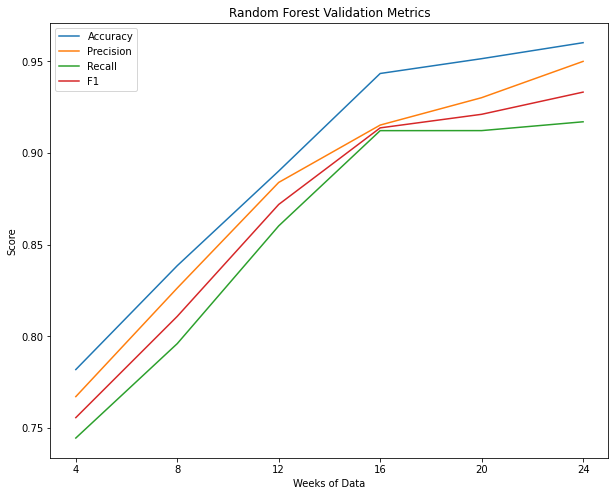

In [ ]:
#Repeat for all models
plt.figure(figsize=(10,8))
plt.plot(ForestValFullMetrics['Accuracy'], label='Accuracy')
plt.plot(ForestValFullMetrics['Precision'], label='Precision')
plt.plot(ForestValFullMetrics['Recall'], label='Recall')
plt.plot(ForestValFullMetrics['F1'], label='F1')
plt.legend(loc='best')
plt.xticks(xtickn)
plt.xlabel('Weeks of Data')
plt.ylabel('Score')
plt.title('Random Forest Validation Metrics')
plt.show()

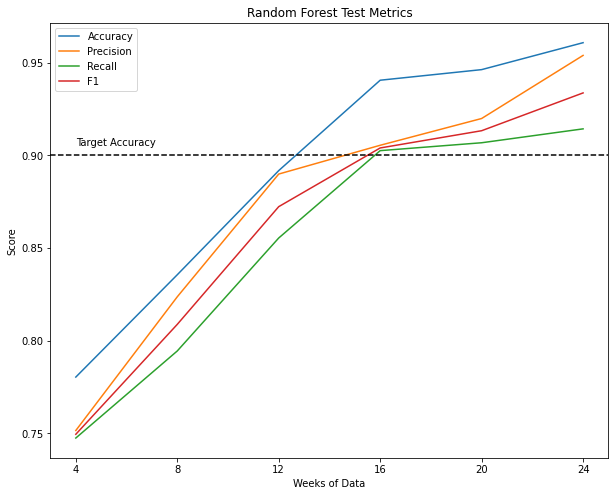

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(ForestTestFullMetrics['Accuracy'], label='Accuracy')
plt.plot(ForestTestFullMetrics['Precision'], label='Precision')
plt.plot(ForestTestFullMetrics['Recall'], label='Recall')
plt.plot(ForestTestFullMetrics['F1'], label='F1')
plt.axhline(y=0.9, color='black', linestyle='--')
plt.text(4,0.905, 'Target Accuracy')
plt.legend(loc='best')
plt.xticks(xtickn)
plt.xlabel('Weeks of Data')
plt.ylabel('Score')
plt.title('Random Forest Test Metrics')
plt.show()

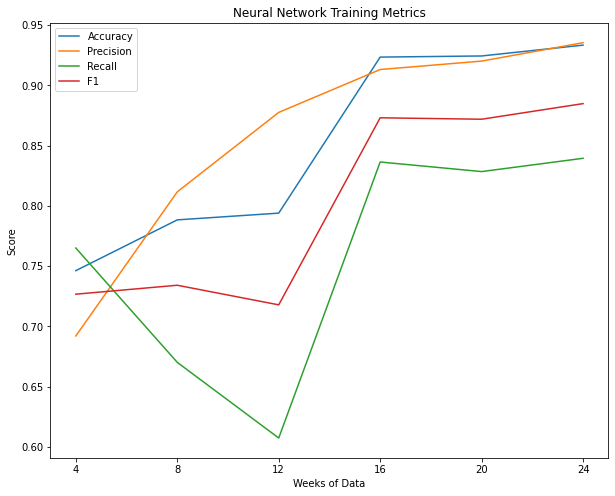

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(NNTrainFullMetrics['Accuracy'], label='Accuracy')
plt.plot(NNTrainFullMetrics['Precision'], label='Precision')
plt.plot(NNTrainFullMetrics['Recall'], label='Recall')
plt.plot(NNTrainFullMetrics['F1'], label='F1')
plt.legend(loc='best')
plt.xticks(xtickn)
plt.xlabel('Weeks of Data')
plt.ylabel('Score')
plt.title('Neural Network Training Metrics')
plt.show()

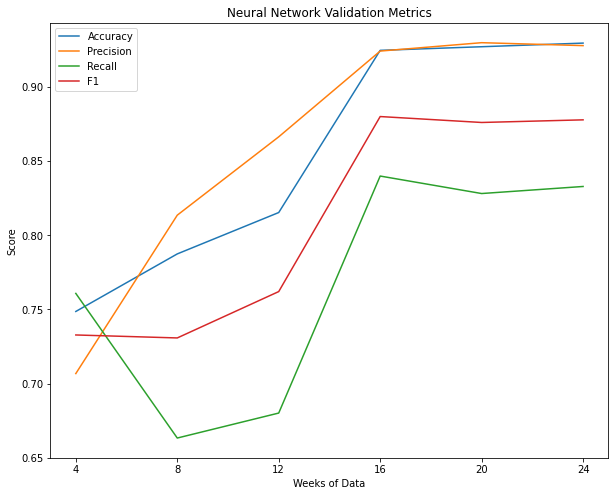

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(NNValFullMetrics['Accuracy'], label='Accuracy')
plt.plot(NNValFullMetrics['Precision'], label='Precision')
plt.plot(NNValFullMetrics['Recall'], label='Recall')
plt.plot(NNValFullMetrics['F1'], label='F1')
plt.legend(loc='best')
plt.xticks(xtickn)
plt.xlabel('Weeks of Data')
plt.ylabel('Score')
plt.title('Neural Network Validation Metrics')
plt.show()

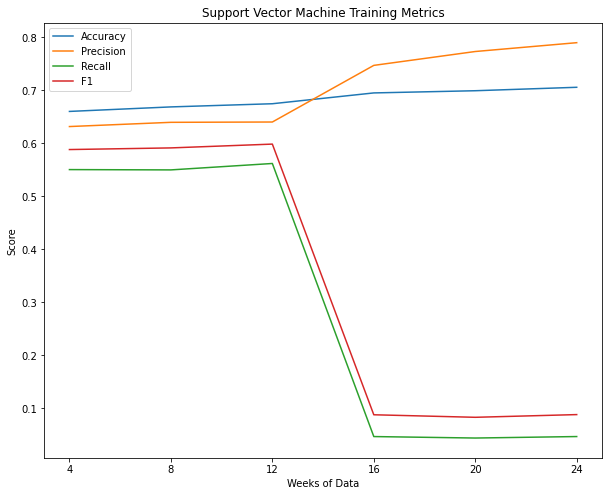

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(SVMTrainFullMetrics['Accuracy'], label='Accuracy')
plt.plot(SVMTrainFullMetrics['Precision'], label='Precision')
plt.plot(SVMTrainFullMetrics['Recall'], label='Recall')
plt.plot(SVMTrainFullMetrics['F1'], label='F1')
plt.legend(loc='best')
plt.xticks(xtickn)
plt.xlabel('Weeks of Data')
plt.ylabel('Score')
plt.title('Support Vector Machine Training Metrics')
plt.show()

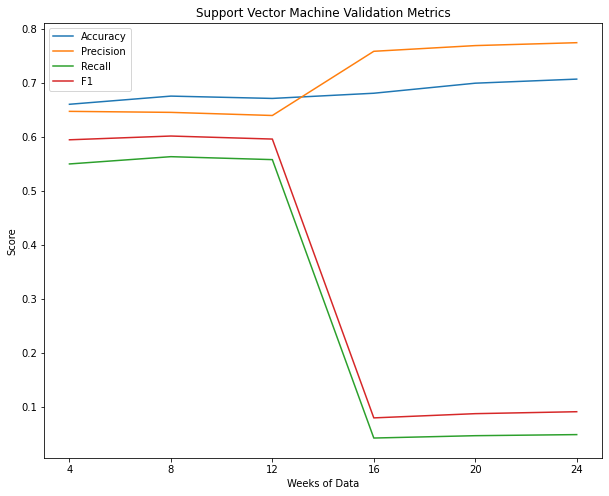

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(SVMValFullMetrics['Accuracy'], label='Accuracy')
plt.plot(SVMValFullMetrics['Precision'], label='Precision')
plt.plot(SVMValFullMetrics['Recall'], label='Recall')
plt.plot(SVMValFullMetrics['F1'], label='F1')
plt.legend(loc='best')
plt.xticks(xtickn)
plt.xlabel('Weeks of Data')
plt.ylabel('Score')
plt.title('Support Vector Machine Validation Metrics')
plt.show()

In [ ]:
#Create plot with all validation accuracies, for comparison between model types
plt.figure(figsize=(10,8))
plt.plot(FullValAccuracy['Support Vector Machine'], label='Support Vector Machine')
plt.plot(FullValAccuracy['Random Forest'], label='Random Forest')
plt.plot(FullValAccuracy['Neural Network'], label='Neural Network')
plt.legend(loc='best')
plt.xticks(xtickn)
plt.xlabel('Weeks of Data')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy for all algorithms over time')
plt.show()